# Bayesian PCA
Includes bias and noise.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from edward.models import Normal, StudentT

from plot_utils import * # see plot_utils.py

import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
%matplotlib inline

In [2]:
%load_ext autoreload

In [3]:
import sys
sys.path.insert(0, tf.__path__[0] + '/contrib/distributions/python/ops')

import bijectors as bijector

In [4]:
ledermann_bound = lambda p: (2*p+1-(8*p+1)**.5)*.5

In [113]:
N, D, K, C = 1000, 20, 3, 2

In [114]:
ledermann_bound(D) # if this is > K, model should be identifiable according to Identifiability of Factor Analysis: Some Results and Open Problems

14.155711229775239

In [115]:
from tensorflow.python.client import device_lib

In [116]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8179493667494525950]

In [117]:
def pairplot(x):
    scattermatrix2 = sns.pairplot(pd.DataFrame(x))
    #[ax.set_ylim(-40,40) for ax in scattermatrix2.axes.flatten()]
    #[ax.set_xlim(-40,40) for ax in scattermatrix2.axes.flatten()];
    plt.show()

In [118]:
def doublepairplot(x,y):
    N = x.shape[0]
    xy = pd.DataFrame(np.c_[np.r_[x,y],np.r_[np.zeros(N),np.ones(N)]])
    names = 'abcdefghijk'[:D+1]
    xy.columns = [i for i in names]
    sns.set()
    scattermatrix = sns.pairplot(xy, hue=names[-1], diag_kind= 'kde', vars = [i for i in names[:-1]])#, plot_kws=dict(alpha=.2))

## P-model

\begin{align}
i \in {1,...,D}\\
j \in {1,...,K}\\
n \in {1,...,N}\\
\tau &\sim StudentT(1,0)\\
\lambda_j &\sim StudentT(1,0)\\
w_{ij}&\sim N(0,|\tau||\lambda_j|)\\
z_{jn}&\sim N(0,1)\\
\mu_i &\sim N(0,1)\\
\sigma_i &\sim Gamma(1,1)\\
x_i&\sim \prod\mathrm{Cat}(\mathcal{S}(W\cdot z)_i+\mu_i,\sigma_i)\\
\end{align}

### The automatic relevance determination in higher dimensions

The ARD might seem like an overkill but it comes in handy in higher dimensions, where the dimensionality of the latent space is not a prior known.  Let us generate a higher dimensional data set and see how ARD determines the latent dimensionality.

In [119]:
class low_rank_categorical_horseshoe_ard():
    def __init__(self,M,D,C):
        # Fit as many latent variables as dimensions, prune by ACD
        K=D
        #########
        # halfCauchy = StudentT(df=1., loc=0., scale=1.)
        # Horseshoe! Happy now, Aki? Hyva!
        #########
        # P-model
        #sigma = ed.models.Gamma(tf.ones([D]),tf.ones([D]))
        tau = StudentT(df=1., loc=tf.zeros([C]), scale=tf.ones([C]), name="tau")
        lamda = StudentT(df=1., loc=tf.zeros([C,K]), scale=tf.ones([C,K]), name="lambda")
        w = Normal(tf.zeros([C, D, K]),    tf.reshape(tf.tile(tf.transpose(tf.reshape(tf.tile(np.abs(tau),[K]),[K,C]))*np.abs(lamda),[1,D]),[C,D,K]), name="W")
            # a factor loading matrix for every variable 
        z = Normal(tf.zeros([M, K]),    tf.ones([M, K]), name="z")
        mu = Normal(tf.zeros([C,D]),       tf.ones([C,D]), name="mu")
            # an offset for every variable 
        x = ed.models.Categorical(tf.nn.softmax(tf.add(tf.transpose(tf.matmul(w,tf.reshape(tf.tile(z,[C,1]),[C,M,K]),transpose_b=True)),tf.transpose(mu))), name="x")

#        self.Pmodel = (sigma,lamda,tau,w,z,mu)
        self.Pmodel = (lamda,tau,w,z,mu) # not sure if observation noise is relevant for categorical data, ask Lars
        self.x = x
        #########
        # Q-model
        qtau = ed.models.TransformedDistribution(
        distribution=ed.models.NormalWithSoftplusScale(tf.Variable(tf.random_normal([C])),
                                                       tf.Variable(tf.random_normal([C]))),
        bijector=bijector.Exp(),
        name="qtau")
        
        qlamda = ed.models.TransformedDistribution(
        distribution=ed.models.NormalWithSoftplusScale(tf.Variable(tf.zeros([C,K])),
                                                       tf.Variable(tf.zeros([C,K]))),
        bijector=bijector.Exp(),
        name="qlamda")
        qw = Normal(tf.Variable(tf.random_normal([C, D, K])),
                    tf.nn.softplus(tf.Variable(tf.random_normal([C, D, K]))), name="qW")
        qz = Normal(tf.Variable(tf.random_normal([M, K])),
                    tf.nn.softplus(tf.Variable(tf.random_normal([M, K]))), name="qz")

        # assume standardized data
        qmu = Normal(tf.Variable(tf.random_normal([C,D])),
                    tf.nn.softplus(tf.Variable(tf.random_normal([C,D]))), name="qmu")
        #qsigma = ed.models.TransformedDistribution(
        #    distribution=ed.models.NormalWithSoftplusScale(tf.Variable(tf.zeros(D)),
        #                                  tf.Variable(tf.ones(D))),
        #    bijector=bijector.Exp(),
        #    name="qsigma")

        #self.Qmodel = (qsigma,qlamda,qtau,qw,qz,qmu)
        self.Qmodel = (qlamda,qtau,qw,qz,qmu)
        
    def initialize(self, x_train):
        '''
        Initialize parameters of Q-model in the solution from PCA, and empirical means and standard deviations, for faster convergence.
        '''
        K=D
        N = x_train.shape[0]
        qsigma,qlamda,qtau,qw,qz,qmu = self.Qmodel
        # set qmu mean to data mean
        data_mean = np.mean(x_train,axis=0).astype(np.float32,copy=False)
        qmu = Normal(tf.Variable(data_mean+tf.random_normal([D])),
                    tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
        # set qsigma mean to data stds
        data_std = np.std(x_train,axis=0).astype(np.float32,copy=False)
        qsigma = ed.models.TransformedDistribution(
            distribution=ed.models.NormalWithSoftplusScale(tf.Variable(np.log(data_std)),
                                          tf.Variable(tf.ones(D)*3)),
            bijector=bijector.Exp(),
            name="qsigma")
        # set qw mean to ppca solution (see 12.61 in Murphy)
        _,S,V = np.linalg.svd(x_train-x_train.mean(0))
        qw = Normal(tf.Variable(np.dot(V,np.diag(S))/np.sqrt(N-1)),
                    tf.nn.softplus(tf.Variable(tf.random_normal([D, K]))))
        self.Qmodel = (qsigma,qlamda,qtau,qw,qz,qmu)

    def infer(self, x_train, n_epoch = 100, n_print=100, n_samples=100, M = 100, optimizer='rmsprop'):
        # add mini-batches
        def generator(arrays, batch_size):
            """Generate batches, one with respect to each array's first axis."""
            starts = [0] * len(arrays)  # pointers to where we are in iteration
            while True:
                batches = []
                for i, array in enumerate(arrays):
                    start = starts[i]
                    stop = start + batch_size
                    diff = stop - array.shape[0]
                    if diff <= 0:
                        batch = array[start:stop]
                        starts[i] += batch_size
                    else:
                        batch = np.concatenate((array[start:], array[:diff]))
                        starts[i] = diff
                    batches.append(batch)
                yield batches
        x_ph = tf.placeholder(tf.int32, [None,D])
        data = generator([x_train], M)
        n_batch = int(N / M)
        # add progress bar
        x = self.x
        inference = ed.KLqp(dict(zip(self.Pmodel,self.Qmodel)), data={x: x_ph})
        inference.initialize(n_iter=n_batch * n_epoch, n_print=(n_batch * n_epoch)/10, n_samples=n_samples, optimizer='rmsprop')

        sess = ed.get_session()
        init = tf.global_variables_initializer()
        init.run()

        # assert x_ph.shape[0] == M 
        learning_curve = []
        for _ in range(inference.n_iter):
            x_batch = next(data)[0]
            info_dict = inference.update({x_ph: x_batch})
            if _%inference.n_print == 0:
                print(info_dict)
            learning_curve.append(info_dict['loss'])
        plt.semilogy(learning_curve)
        plt.show()
    
    def prior_predictive_check(self):
        self.x_prior = ed.copy(self.x)
        pass
        
    def posterior_predictive_check(self, x_test):
        self.x_post = ed.copy(self.x, dict(zip(self.Pmodel,self.Qmodel)))
        return ed.evaluate('log_likelihood', data={self.x_post: x_test})
    
    def plot_histograms(self,n_hist=3000):
        for variable in meddle.Qmodel:
            plt.show()
            if all([i < 10 for i in variable.shape]):
                samples = variable.sample(n_hist).eval()
            else:
                samples = variable.sample().eval()
            if variable.shape == []:
                plt.hist(samples,'auto')
                plt.title(variable.name)
            else:
                for dimension in range(variable.shape[0]):
                    plt.hist(samples[:,dimension],'auto')
                    plt.title(variable.name)
                    
    def print_model(self):
        qsigma,qlamda,qtau,qw,qz,qmu = self.Qmodel
        # add pair plots
        print("Inferred principal axes (columns):")
        print(qw.mean().eval())
        print(qw.variance().eval())
        print("Inferred center:")
        print(qmu.mean().eval())
        print(qmu.variance().eval())

In [120]:
M = 100
meddle = low_rank_categorical_horseshoe_ard(M,D,C)
#meddle.initialize(x_train)

In [121]:
#meddle.prior_predictive_check()

In [122]:
W_prior.shape

(2, 3, 3)

In [123]:
meddle.Pmodel

(<ed.RandomVariable 'lambda_4/' shape=(2, 20) dtype=float32>,
 <ed.RandomVariable 'tau_4/' shape=(2,) dtype=float32>,
 <ed.RandomVariable 'W_4/' shape=(2, 20, 20) dtype=float32>,
 <ed.RandomVariable 'z_4/' shape=(100, 20) dtype=float32>,
 <ed.RandomVariable 'mu_4/' shape=(2, 20) dtype=float32>)

Reponse 0


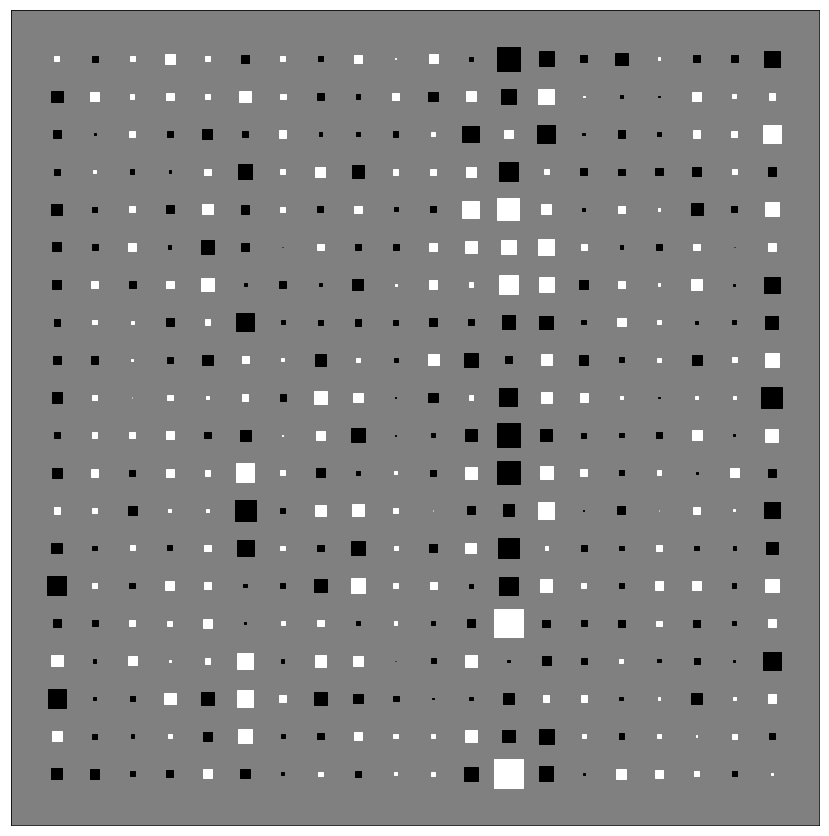

Reponse 1


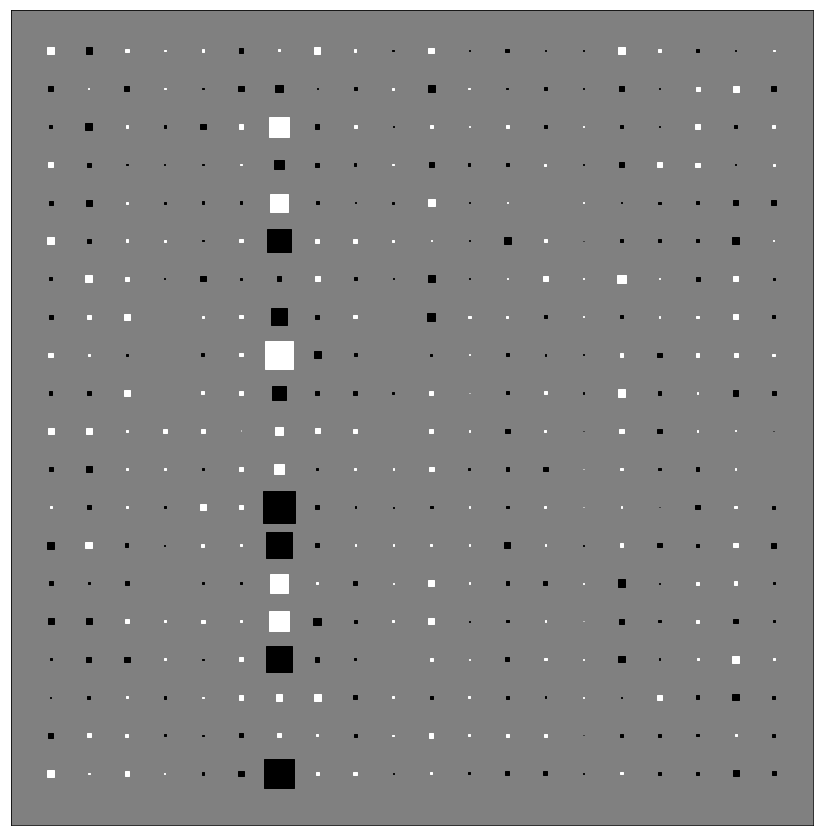

In [124]:
sess = ed.get_session()
tmp = sess.run([v.value() for v in [meddle.x, [var for var in meddle.Pmodel if var.name.startswith('W')][0]]])
sampled_from_prior,W_prior = tmp
np.round(W_prior,1)
for i in range(C):
    print("Reponse %i"%(i))
    hinton(W_prior[i].T)
    plt.show()

In [125]:
x_train = sampled_from_prior

In [126]:
x_train

array([[1, 1, 0, ..., 1, 1, 1],
       [1, 0, 1, ..., 0, 0, 1],
       [1, 1, 0, ..., 0, 0, 0],
       ..., 
       [1, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 1, 1]], dtype=int32)

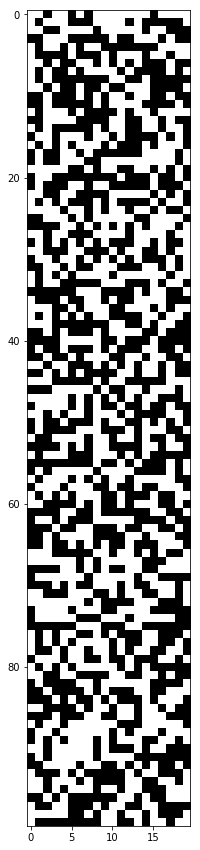

In [127]:
plt.imshow(x_train,cmap='gray')
plt.rcParams['figure.figsize'] = (15,15)

In [128]:
np.corrcoef(x_train.T)

array([[ 1.        ,  0.06086087,  0.03887781,  0.08242959, -0.00282842,
        -0.15911844,  0.020004  , -0.1183894 ,  0.07798346,  0.03961585,
         0.23969588, -0.06181043, -0.01846286,  0.04041617,  0.15882774,
        -0.04041617, -0.03819908, -0.10090092,  0.16634979,  0.04128262],
       [ 0.06086087,  1.        , -0.17806305,  0.13679462, -0.01455488,
         0.17806305,  0.16012815,  0.01455488, -0.21670595,  0.14094097,
         0.10090092,  0.08353438,  0.15743018,  0.13933936,  0.02414023,
        -0.21941946,  0.0563272 , -0.07852564, -0.1090673 ,  0.13795876],
       [ 0.03887781, -0.17806305,  1.        ,  0.00604111,  0.11291345,
        -0.15696507, -0.14025268, -0.07244268,  0.15338422, -0.04128262,
         0.11903823,  0.09567849, -0.13587953, -0.11903823,  0.07450703,
        -0.08136283, -0.15505517,  0.09785447,  0.13321188, -0.11682055],
       [ 0.08242959,  0.13679462,  0.00604111,  1.        ,  0.05481186,
         0.15505517,  0.10050378, -0.01421048, -

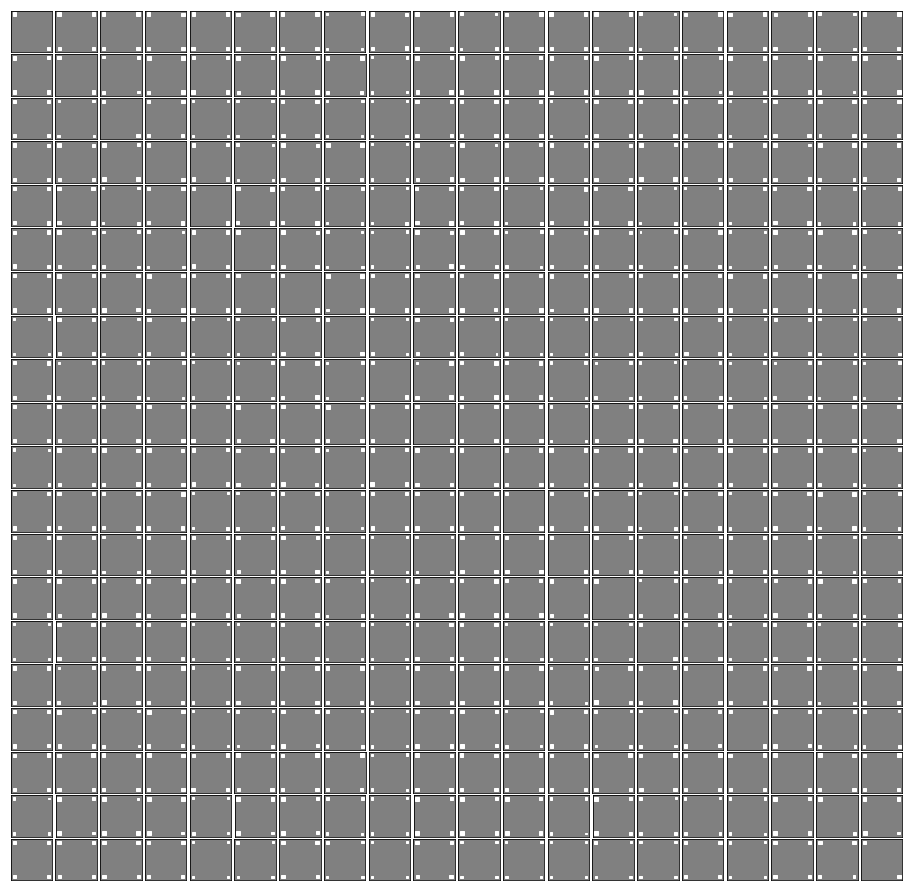

In [129]:
plt.figure(figsize=(16,16)) 
gs1 = gridspec.GridSpec(D, D)
gs1.update(wspace=0.05, hspace=0.05) # set the spacing between axes. 
c = 0
for i in range(D):
    for j in range(D):
        ax1 = plt.subplot(gs1[c])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        hinton(np.histogram2d(x_train[:,i],x_train[:,j],normed=True)[0])
        plt.tight_layout()
        c += 1

sess = ed.get_session()
model = meddle.x.get_ancestors()
model.append(meddle.x)
model_sample = dict(zip(model,sess.run([[v.value() for i in range(10)] for v in model])))

meddle.prior_predictive_check()

# sample all variables ancestrally
model = meddle.x_prior.get_ancestors()
model.append(meddle.x_prior)
model_sample = dict(zip(model,sess.run([v.value() for v in model])))

sess = ed.get_session()
tmp = meddle.x_prior.sample().eval().T
with sess.as_default():
    plt.scatter(*tmp)
    plt.scatter(*x_train[:,:M])
    plt.axis('equal')
    plt.show()

In [101]:
N

1000

In [102]:
M

100

{'loss': 6254.3779, 't': 1}
{'loss': 1721.5503, 't': 201}
{'loss': 1582.7429, 't': 401}
{'loss': 1561.8157, 't': 601}
{'loss': 1550.9678, 't': 801}
{'loss': 1550.4727, 't': 1001}
{'loss': 1551.2141, 't': 1201}
{'loss': 1541.187, 't': 1401}
{'loss': 1533.2292, 't': 1601}
{'loss': 1531.46, 't': 1801}


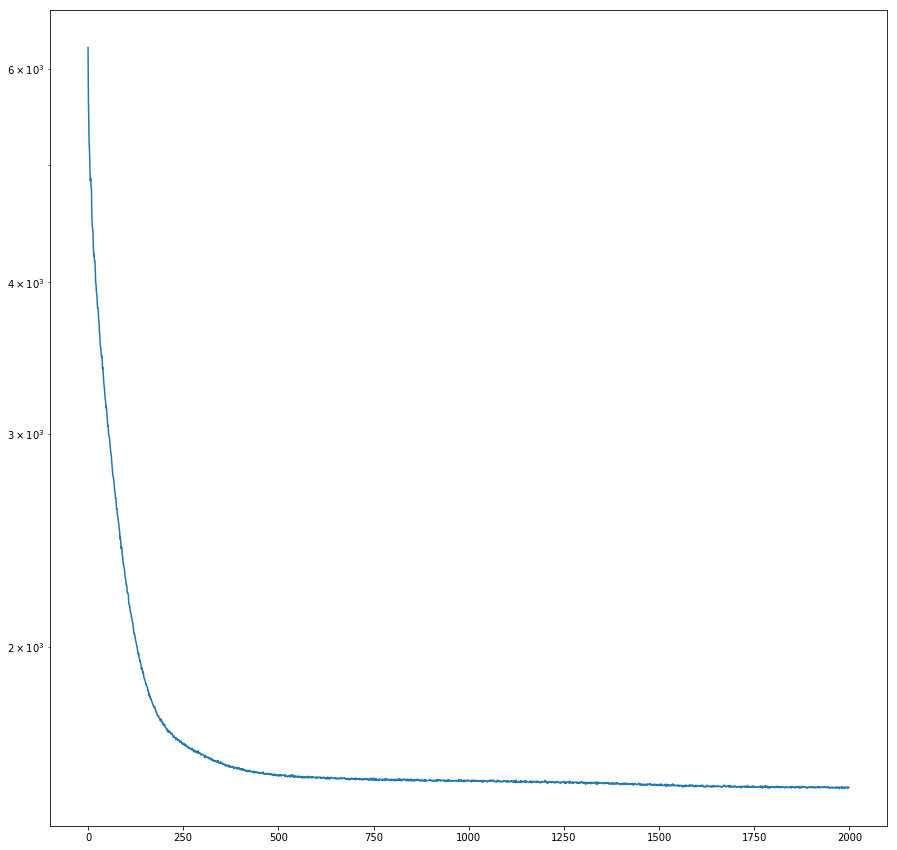

In [130]:
meddle.infer(x_train, M=M, n_epoch = 200, n_samples = 70)

In [131]:
meddle.posterior_predictive_check(x_train[:M,:])

-0.65800959

In [132]:
foo = meddle.x_post.sample().eval()

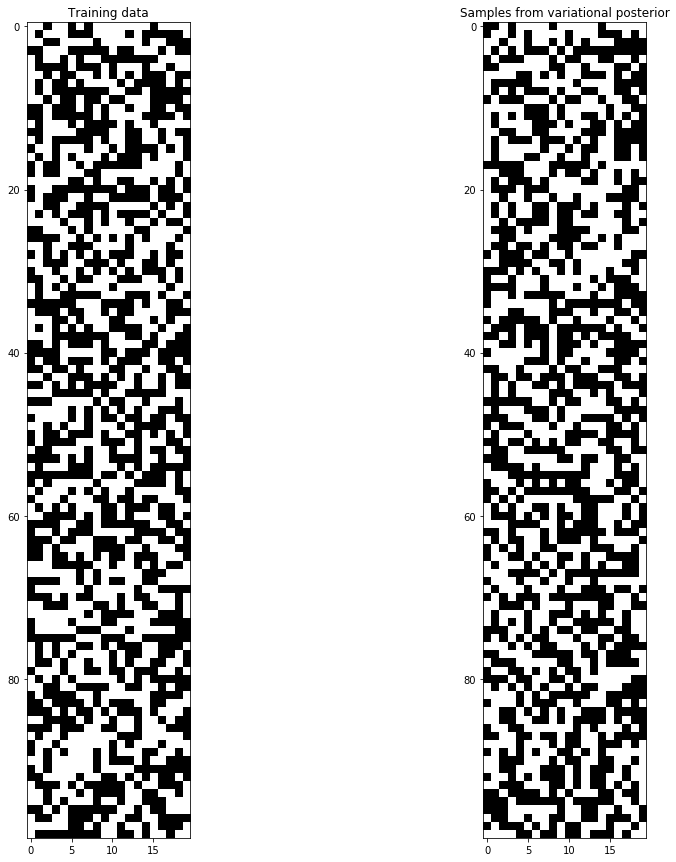

In [136]:
plt.subplot(121)
plt.imshow(x_train,cmap='gray')
plt.title('Training data')
plt.subplot(122)
plt.imshow(foo,cmap='gray')
plt.title('Samples from variational posterior')
plt.rcParams['figure.figsize'] = (15,15)

In [46]:
meddle.Qmodel

(<ed.RandomVariable 'qsigma_1/' shape=(8,) dtype=float32>,
 <ed.RandomVariable 'qlamda/' shape=(8,) dtype=float32>,
 <ed.RandomVariable 'qtau/' shape=() dtype=float32>,
 <ed.RandomVariable 'Normal_8/' shape=(8, 8) dtype=float32>,
 <ed.RandomVariable 'Normal_5/' shape=(100, 8) dtype=float32>,
 <ed.RandomVariable 'Normal_7/' shape=(8,) dtype=float32>)

In [28]:
qwmode = meddle.Qmodel[3].mode().eval()

In [32]:
np.round(qwmode,2)

array([[ 5.82999992,  0.        ,  0.19      , -0.        , -0.01      ,
        -0.01      , -0.01      ,  0.01      ],
       [-9.94999981,  0.01      , -0.03      ,  0.        , -0.        ,
        -0.02      ,  0.02      , -0.01      ],
       [-0.34999999,  0.        , -0.50999999,  0.        , -0.        ,
         0.        ,  0.34      , -0.01      ],
       [-5.94999981, -0.        ,  0.11      , -0.        , -0.        ,
         0.01      ,  0.57999998,  0.        ],
       [-0.47999999,  0.01      ,  0.87      , -0.        , -0.        ,
         0.01      ,  0.47      ,  0.02      ],
       [-1.25999999, -0.01      ,  0.28999999, -0.01      , -0.        ,
        -0.        , -0.30000001, -0.        ],
       [-0.66000003,  0.        , -0.01      , -0.        ,  0.01      ,
         0.01      , -0.27000001,  0.        ],
       [ 2.27999997,  0.        ,  0.37      ,  0.        ,  0.        ,
         0.        , -0.60000002, -0.02      ]], dtype=float32)

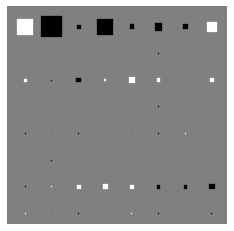

In [29]:
hinton(qwmode)

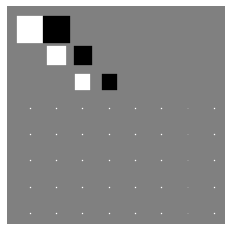

In [82]:
hinton(np.pad(w_true,((0,0),(0,D-K)), 'constant', constant_values=0.001))

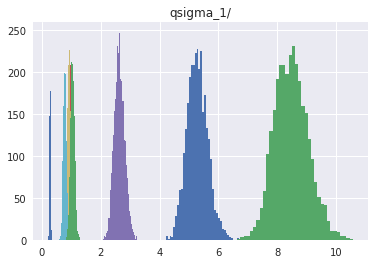

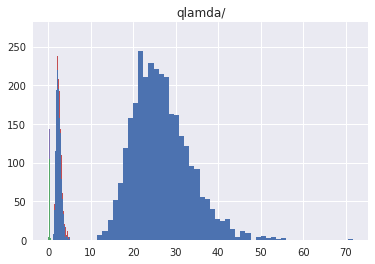

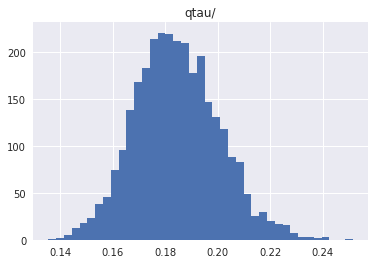

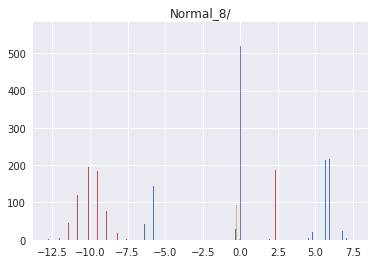

IndexError: index 8 is out of bounds for axis 1 with size 8

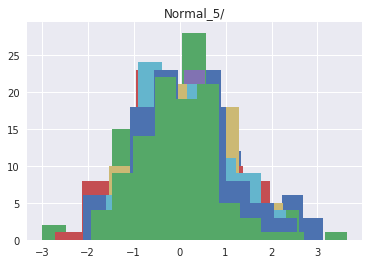

In [24]:
meddle.plot_histograms()

## W_hat

In [ ]:
w_hat = meddle.Qmodel[3].mean().eval()
hinton(w_hat.T)
plt.show()

np.round(w_hat,1)

w_true

hinton(w_true.T)
plt.show()

## PCA solution:

In [ ]:
U,S,V = np.linalg.svd(x_train-x_train.mean(0))
#np.dot(V,np.diag(S))/np.sqrt(N-1)
whitened = np.sqrt(N-1)*U

In [ ]:
W_hat = np.dot(V,np.diag(S))/np.sqrt(N-1)

In [ ]:
white = np.random.normal(size=x_train.shape)

In [ ]:
tmp = np.dot(white,W_hat).T+x_train.mean(0)[:,np.newaxis]

In [ ]:
tmp.shape

In [ ]:
doublepairplot(x_train,tmp.T)

In [ ]:
pairplot(white)

In [ ]:
qsigma.get_variables()[0].eval()

sorted(np.exp(qsigma.get_variables()[0].eval()))

tmp = qw.mean().eval()

tmp[abs(tmp)>0.05]

sigma

In [ ]:
alphas=tf.exp(qalpha.distribution.mean()).eval()
alphas.sort()
plt.plot(range(alphas.size),alphas)
plt.show()

In [ ]:
plt.hist(qalpha.sample(1000).eval(),bins=20)
plt.xlim(0,2)
plt.show()

In [ ]:
qsigma.get_variables()[0].eval()

In [ ]:
x_train.shape

In [ ]:
x_sim_sample = x_sim.sample().eval()

In [ ]:
x_sim_sample

In [ ]:
x_sim_sample.shape

In [ ]:
D

In [ ]:
sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()
tpm = qtmp.sample(10000).eval()

plt.hist(tpm[:,0],'auto',normed=True)
plt.axis([0,50,0,1])
plt.show()
plt.hist(np.log(tpm[:,0]),'auto',normed=True)
plt.show()

In [ ]:
x_train.shape